In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import pyproj
from pyproj import Transformer
from datetime import datetime, timedelta
import os, fnmatch, glob
import cmocean 
import rasterio
from rasterio.plot import show
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.windblow import WindBlow


/home/maltem/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Load Surface data

In [2]:
date = datetime.strptime('2024-04-11 10:00:00','%Y-%m-%d %H:%M:%S') 

# Load visible MODIS satellite image
datetime_str = datetime.strftime(date, '%Y-%m-%d')
geotiff_path = '/home/maltem/work/python/SvalMIZ2024/data/snapshot-'+datetime_str+'T00_00_00Z.tif'

# Load MODIS skin temperture
istmodis_path= '/lustre/storeB/users/maltem/SALIENSEAS/SvalMIZ2024/observations/remotesensing/aa-modis-2024.nc'
istIn = xr.open_mfdataset(istmodis_path)


# Load SeaIce             -----------------------------------#
dir_seaiceproduct_hres= '/lustre/storeB/project/fou/hi/oper/barents_eps/archive/obs/'
file_name_stub         = 'barents_icec-obs_%s' #barents_icec-obs_20240415T00Z.nc
datetime_str = datetime.strftime(date, '%Y%m%d')
file_prename = file_name_stub % datetime_str
infile_name = glob.glob(dir_seaiceproduct_hres + file_prename + '*.nc')
if infile_name:
    IceIn = xr.open_mfdataset(infile_name)
    lats = np.array(IceIn['lat'])
    lons = np.array(IceIn['lon'])
    sicn = np.array(IceIn['ice_conc'])
    sicn=np.squeeze(np.where(sicn<0.1,np.nan,sicn))

    
#Load OMB data
OMBraw = xr.open_mfdataset('/home/maltem/work/python/SvalMIZ2024/data/cruise/2024_KVS_deployment.nc')    

In [3]:
with rasterio.open(geotiff_path, 'r') as src:
    raster_crs = src.crs
    print(raster_crs)
    left, bottom, right, top = src.bounds
    landsat = src.read()[0, :, :]
    landsat = np.ma.masked_where(landsat <= 0,
                                 landsat,
                                 copy=True)
    landsat = (landsat - np.min(landsat)) / (np.max(landsat) - np.min(landsat))        

EPSG:3413


In [4]:
aist=istIn.sel(time=date,method='nearest')


## Start Opendrift Windblow model

In [5]:
import sys
sys.path.append('/home/maltem/miniforge3/envs/opendrift/lib/python3.11/site-packages')

In [6]:
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.windblow import WindBlow

o = WindBlow(loglevel=20)  # Set loglevel to 0 for debug information


reader_arome = reader_netCDF_CF_generic.Reader('https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc')
#reader_arome = reader_netCDF_CF_generic.Reader('https://thredds.met.no/thredds/dodsC/mepslatest/meps_lagged_6_h_latest_2_5km_latest.nc')

#reader_arome = reader_netCDF_CF_generic.Reader(o.test_data_folder() +
#    '2Feb2016_Nordic_sigma_3d/AROME_MetCoOp_00_DEF_20160202_subset.nc')

o.add_reader([reader_arome])

lat = 79.85;  lon = 18.5  # 
lat = 79.75;  lon = 18  # 
#lat = 81.45;  lon = 17.5  # 
o.seed_elements(lon, lat, radius=500, number=1,
                time=reader_arome.start_time)

#o.run(steps=48*4, time_step=900, time_step_output=3600, outfile='test.nc')
o.run(steps=48*4, time_step=900, time_step_output=3600, outfile='test.nc')

for attribute, value in o.__dict__.items():
    #print(attribute, '=', value)
    if attribute=='history':
        a=value
        
latw=np.array((a['lat'])); lonw=np.array((a['lon']));         


11:52:10 INFO    opendrift.models.basemodel:515: OpenDriftSimulation initialised (version 1.11.13 / v1.11.13-11-gfa23a9f)
11:52:10 INFO    opendrift.readers.reader_netCDF_CF_generic:102: Opening dataset: https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc
11:52:12 INFO    opendrift.readers.reader_netCDF_CF_generic:314: Detected dimensions: {'time': 'time', 'x': 'x', 'y': 'y'}
09:52:12 INFO    opendrift.models.basemodel:2038: 2024-04-11 00:00:00 - step 1 of 192 - 1 active elements (0 deactivated)
09:52:12 INFO    opendrift.models.basemodel:2038: 2024-04-11 00:15:00 - step 2 of 192 - 1 active elements (0 deactivated)
09:52:12 INFO    opendrift.models.basemodel:2038: 2024-04-11 00:30:00 - step 3 of 192 - 1 active elements (0 deactivated)
09:52:12 INFO    opendrift.models.basemodel:2038: 2024-04-11 00:45:00 - step 4 of 192 - 1 active elements (0 deactivated)
09:52:12 INFO    opendrift.models.basemodel:2038: 2024-04-11 01:00:00 - step 5 

09:52:18 INFO    opendrift.models.basemodel:2038: 2024-04-11 14:45:00 - step 60 of 192 - 1 active elements (0 deactivated)
09:52:18 INFO    opendrift.models.basemodel:2038: 2024-04-11 15:00:00 - step 61 of 192 - 1 active elements (0 deactivated)
09:52:18 INFO    opendrift.models.basemodel:2038: 2024-04-11 15:15:00 - step 62 of 192 - 1 active elements (0 deactivated)
09:52:18 INFO    opendrift.models.basemodel:2038: 2024-04-11 15:30:00 - step 63 of 192 - 1 active elements (0 deactivated)
09:52:18 INFO    opendrift.models.basemodel:2038: 2024-04-11 15:45:00 - step 64 of 192 - 1 active elements (0 deactivated)
09:52:18 INFO    opendrift.models.basemodel:2038: 2024-04-11 16:00:00 - step 65 of 192 - 1 active elements (0 deactivated)
09:52:18 INFO    opendrift.models.basemodel:2038: 2024-04-11 16:15:00 - step 66 of 192 - 1 active elements (0 deactivated)
09:52:19 INFO    opendrift.models.basemodel:2038: 2024-04-11 16:30:00 - step 67 of 192 - 1 active elements (0 deactivated)
09:52:19 INFO   

09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 06:00:00 - step 121 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc (-17.96-79.55E, 62.13-87.57N)
09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 06:15:00 - step 122 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc (-17.96-79.55E, 62.13-87.57N)
09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 06:30:00 - step 123 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79

09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc (-17.96-79.55E, 62.13-87.57N)
09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 11:30:00 - step 143 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc (-17.96-79.55E, 62.13-87.57N)
09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 11:45:00 - step 144 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_

09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 16:45:00 - step 164 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc (-17.96-79.55E, 62.13-87.57N)
09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 17:00:00 - step 165 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc (-17.96-79.55E, 62.13-87.57N)
09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 17:15:00 - step 166 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79

09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc (-17.96-79.55E, 62.13-87.57N)
09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 22:15:00 - step 186 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_20240411T00Z.nc (-17.96-79.55E, 62.13-87.57N)
09:52:23 INFO    opendrift.models.basemodel:2038: 2024-04-12 22:30:00 - step 187 of 192 - 1 active elements (0 deactivated)
09:52:23 INFO    opendrift.models.basemodel.environment:648: All 1 particles (-11.76--11.76E, 79.31-79.31N) are outside domain of https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/04/11/arome_arctic_det_2_5km_

In [7]:
latw=np.array((a['lat'])); lonw=np.array((a['lon']));       

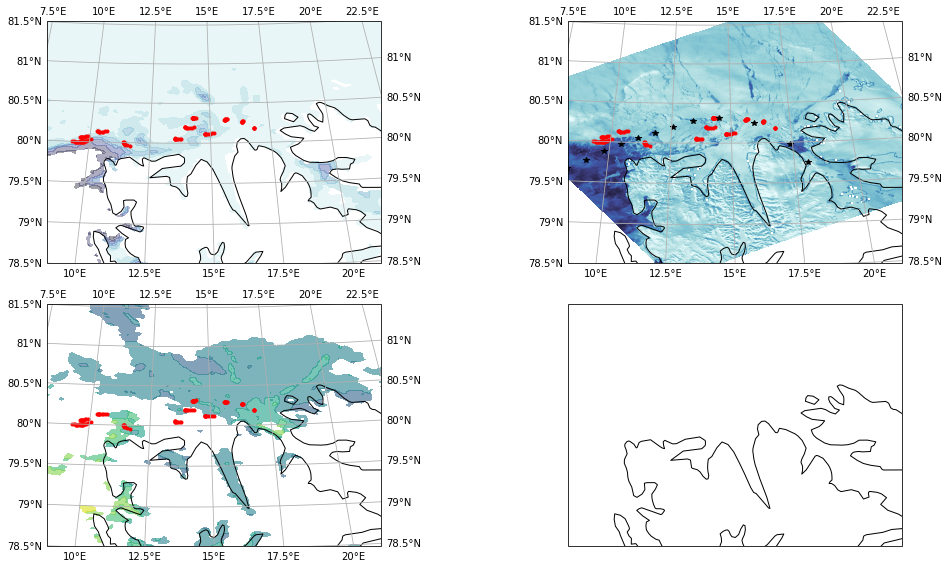

In [9]:
# Create the projection
plot_proj = ccrs.Orthographic(14,25)

fig, ax = plt.subplots(figsize=(15, 8),nrows=2,ncols=2,
                       subplot_kw={'projection': plot_proj})

for i in range(2):
    for j in range(2):
        ax[i,j].coastlines(resolution='50m')
        ax[i,j].set_extent([9, 21, 78.5, 81.5], crs=ccrs.PlateCarree())

# -- Subplot - 1- #
#    AMSR2 sea-ice contour
contour1 = ax[0,0].contourf(lons, lats, sicn, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice,alpha=0.4)

# -- Subplot - 2- #
#    MODIS infrared surface temperature
contour2 = ax[1,0].contourf(lons, lats, np.flip(np.array(aist.modis_sist),axis=0), transform=ccrs.PlateCarree(),alpha=.6)

# -- Subplot - 3- #
#    MODIS visible satellite picture
contour3 = ax[0,1].imshow(landsat, transform=ccrs.epsg(3413),cmap=cmocean.cm.ice,extent=(left, right, bottom, top))



#Plot the buoy trajectories
#timenow = np.datetime64(date)
#timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10

startdate = date
timesteps_to_loop=24*3
timesteps_to_loop=10

for dt in range(timesteps_to_loop): #MAKE LOOP
    date = startdate + timedelta(hours=dt*1)
    #------------------------------------------------------------#
    #Find all buoys at date times closer than 29 minutes
    timenow = np.datetime64(date)
    timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10

    for buoy_no in range(np.min(np.shape(timemask))):
        tb = np.where(timemask[buoy_no,:]); #tb = [x[0] for x in tb1]
        if tb:
            ax[0,0].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())
            ax[1,0].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())
            ax[0,1].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())

ax[0,1].plot(lonw,latw,'-',marker='*',linewidth=10,color='k',transform = ccrs.PlateCarree())
ax[1,1].plot(lonw,latw,'-',color='k',transform = ccrs.Geodetic())
#plt.plot([-120, -64], [20, 60], 'o-', color='blue',  transform=ccrs.Geodetic())
# Add color bar
#cbar = plt.colorbar(contour1, ax=ax[0,0], orientation='horizontal', pad=0.05)
#cbar.set_label('Variable Units')  # Replace with the actual units of your variable

# Add gridlines and labels
ax[0,0].gridlines(draw_labels=True)
ax[1,0].gridlines(draw_labels=True)
ax[0,1].gridlines(draw_labels=True)
# Display the plot
plt.show()

## Collect Model Data along the trajectory

#### Build a versatile tool to collect data from the various models

In [281]:
def makeWinddrift(model,seedlon,seedlat,initime,no_seeds):
    o = WindBlow(loglevel=20)  
    ofilename = 'tmp_transfer.nc'
    
    if model=='MET-AROME':
        
        year = datetime.strftime(initime, '%Y')
        month = datetime.strftime(initime, '%m')
        day = datetime.strftime(initime, '%d')
        
        fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/'
        fc_data_path=fc_data_path + year +"/"+ month  +"/"+ day+"/" 
        fc_file = fc_data_path + 'arome_arctic_det_2_5km_'+year+month+day+'T00Z.nc'

        reader_arome = reader_netCDF_CF_generic.Reader(fc_file)
        o.add_reader([reader_arome])

        #lat = 79.85;  lon = 18.5# 
        #lat = 79.75;  lon = 18  # 
        o.seed_elements(seedlon, seedlat, radius=3500, number=no_seeds, time=reader_arome.start_time)

        o.run(steps=4*48, time_step=900, time_step_output=3600, outfile=ofilename)

        for attribute, value in o.__dict__.items():
            #print(attribute, '=', value)
            if attribute=='history':
                a=value
        
        latw=np.array((a['lat'])); lonw=np.array((a['lon']));   
        
        return ofilename

In [282]:
# Find index on a irregular grid:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

In [283]:
def getModelTrajectoryForecast(model,initime,traj_filename):
    
    inDomain=True
    
    WindTraj = xr.open_mfdataset(ofilename)
    
    ttime = WindTraj.time
    tlat  = np.squeeze(np.array(WindTraj.lat))
    tlon  = np.squeeze(np.array(WindTraj.lon))
    tray  = np.squeeze(np.array(WindTraj.trajectory))
    print('Number of trajectories',len(tray))
    print('Number of time steps',len(tlat[0,:]))
    
    t2m=np.zeros((len(tray),len(tlat[0,:])))
    sic=np.zeros((len(tray),len(tlat[0,:])))
    lat=np.zeros((len(tray),len(tlat[0,:])))
    lon=np.zeros((len(tray),len(tlat[0,:])))

    print(np.shape(t2m))
    WindTraj.close()
    if model=='MET-AROME':
        #initialization only at 00 for now
        
        year = datetime.strftime(initime, '%Y')
        month = datetime.strftime(initime, '%m')
        day = datetime.strftime(initime, '%d')
        
        fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/'
        fc_data_path=fc_data_path + year +"/"+ month  +"/"+ day+"/" 
        fc_file = fc_data_path + 'arome_arctic_det_2_5km_'+year+month+day+'T00Z.nc'      
        fc = xr.open_dataset(fc_file)
        
        [imax,jmax] = np.shape(fc['latitude'])
        
        for ens in range(len(tray)):
        
            for i in range(len(tlat[0,:])):

                [ix,jx] = findindex(fc['latitude'],fc['longitude'],tlat[ens,i],tlon[ens,i]) # For example for Longyearbyen
            
                if (ix==0 or jx == 0 or ix==imax or jx==jmax):
                    inDomain = False
                    print ('Out of Domain',i)
                else:
                    inDomain= True
            
                if (inDomain):
            
                    fctime = fc.sel(time=ttime[i],method='nearest')
            
                    t2m_nc = fctime['air_temperature_2m'].isel(y=ix, x=jx)
                    sic[ens,i]=float(fctime['SFX_SIC'].isel(y=ix, x=jx))
                    t2m[ens,i]=float(t2m_nc.values)
                    lat[ens,i]=float(tlat[ens,i])
                    lon[ens,i]=float(tlon[ens,i])
                
                else:
                    t2m[ens,i]=np.nan
                    lat[ens,i]=np.nan
                    lon[ens,i]=np.nan
    fc.close()
    return WindTraj.time,lat,lon,np.array(t2m),np.array(sic)

### Run opendrift and forecast model temperature extraction:

In [284]:
# Set initial time
date = datetime.strptime('2024-04-12 10:00:00','%Y-%m-%d %H:%M:%S') 

traj_filename = makeWinddrift('MET-AROME',18.,79.89,date,20)



16:20:12 INFO    opendrift.models.basemodel:515: OpenDriftSimulation initialised (version 1.11.13 / v1.11.13-11-gfa23a9f)
16:20:12 INFO    opendrift.readers.reader_netCDF_CF_generic:102: Opening dataset: /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc
16:20:18 INFO    opendrift.readers.reader_netCDF_CF_generic:314: Detected dimensions: {'time': 'time', 'x': 'x', 'y': 'y'}
16:20:18 INFO    opendrift.models.basemodel:2038: 2024-04-12 00:00:00 - step 1 of 192 - 20 active elements (0 deactivated)
16:20:18 INFO    opendrift.models.basemodel:2038: 2024-04-12 00:15:00 - step 2 of 192 - 20 active elements (0 deactivated)
16:20:19 INFO    opendrift.models.basemodel:2038: 2024-04-12 00:30:00 - step 3 of 192 - 20 active elements (0 deactivated)
16:20:19 INFO    opendrift.models.basemodel:2038: 2024-04-12 00:45:00 - step 4 of 192 - 20 active elements (0 deactivated)
16:20:19 INFO    opendrift.models.basemodel:2

16:20:25 INFO    opendrift.models.basemodel:2038: 2024-04-12 15:45:00 - step 64 of 192 - 20 active elements (0 deactivated)
16:20:25 INFO    opendrift.models.basemodel:2038: 2024-04-12 16:00:00 - step 65 of 192 - 20 active elements (0 deactivated)
16:20:25 INFO    opendrift.models.basemodel:2038: 2024-04-12 16:15:00 - step 66 of 192 - 20 active elements (0 deactivated)
16:20:26 INFO    opendrift.models.basemodel:2038: 2024-04-12 16:30:00 - step 67 of 192 - 20 active elements (0 deactivated)
16:20:26 INFO    opendrift.models.basemodel:2038: 2024-04-12 16:45:00 - step 68 of 192 - 20 active elements (0 deactivated)
16:20:26 INFO    opendrift.models.basemodel:2038: 2024-04-12 17:00:00 - step 69 of 192 - 20 active elements (0 deactivated)
16:20:26 INFO    opendrift.models.basemodel:2038: 2024-04-12 17:15:00 - step 70 of 192 - 20 active elements (0 deactivated)
16:20:26 INFO    opendrift.models.basemodel:2038: 2024-04-12 17:30:00 - step 71 of 192 - 20 active elements (0 deactivated)
16:20:26

16:20:30 INFO    opendrift.models.basemodel:2038: 2024-04-13 01:30:00 - step 103 of 192 - 20 active elements (0 deactivated)
16:20:30 WARNING opendrift.readers.basereader.structured:324: Data block from /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc not large enough to cover element positions within timestep. Buffer size (20) must be increased. See `Variables.set_buffer_size`.
16:20:30 INFO    opendrift.models.basemodel:2038: 2024-04-13 01:45:00 - step 104 of 192 - 20 active elements (0 deactivated)
16:20:30 WARNING opendrift.readers.basereader.structured:324: Data block from /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc not large enough to cover element positions within timestep. Buffer size (20) must be increased. See `Variables.set_buffer_size`.
16:20:30 INFO    opendrift.models.basemodel:2038: 2024-04-13 0

16:20:30 INFO    opendrift.models.basemodel:2038: 2024-04-13 07:30:00 - step 127 of 192 - 20 active elements (0 deactivated)
16:20:30 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-14.12--13.31E, 77.13-77.57N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:20:30 INFO    opendrift.models.basemodel:2038: 2024-04-13 07:45:00 - step 128 of 192 - 20 active elements (0 deactivated)
16:20:30 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-14.12--13.31E, 77.13-77.57N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:20:30 INFO    opendrift.models.basemodel:2038: 2024-04-13 08:00:00 - step 129 of 192 - 20 active elements (0 deactivated)
16:20:30 INFO    opendrift.mode

16:20:31 INFO    opendrift.models.basemodel:2038: 2024-04-13 12:30:00 - step 147 of 192 - 20 active elements (0 deactivated)
16:20:31 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-14.12--13.31E, 77.13-77.57N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:20:31 INFO    opendrift.models.basemodel:2038: 2024-04-13 12:45:00 - step 148 of 192 - 20 active elements (0 deactivated)
16:20:31 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-14.12--13.31E, 77.13-77.57N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:20:31 INFO    opendrift.models.basemodel:2038: 2024-04-13 13:00:00 - step 149 of 192 - 20 active elements (0 deactivated)
16:20:31 INFO    opendrift.mode

16:20:31 INFO    opendrift.models.basemodel:2038: 2024-04-13 17:30:00 - step 167 of 192 - 20 active elements (0 deactivated)
16:20:31 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-14.12--13.31E, 77.13-77.57N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:20:31 INFO    opendrift.models.basemodel:2038: 2024-04-13 17:45:00 - step 168 of 192 - 20 active elements (0 deactivated)
16:20:31 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-14.12--13.31E, 77.13-77.57N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:20:31 INFO    opendrift.models.basemodel:2038: 2024-04-13 18:00:00 - step 169 of 192 - 20 active elements (0 deactivated)
16:20:31 INFO    opendrift.mode

16:20:31 INFO    opendrift.models.basemodel:2038: 2024-04-13 22:30:00 - step 187 of 192 - 20 active elements (0 deactivated)
16:20:31 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-14.12--13.31E, 77.13-77.57N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:20:31 INFO    opendrift.models.basemodel:2038: 2024-04-13 22:45:00 - step 188 of 192 - 20 active elements (0 deactivated)
16:20:31 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-14.12--13.31E, 77.13-77.57N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/12/arome_arctic_det_2_5km_20240412T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:20:31 INFO    opendrift.models.basemodel:2038: 2024-04-13 23:00:00 - step 189 of 192 - 20 active elements (0 deactivated)
16:20:31 INFO    opendrift.mode

### Load the corresponding remote sending sea-ice fields 

In [285]:
# Load visible MODIS satellite image
datetime_str = datetime.strftime(date, '%Y-%m-%d')
geotiff_path = '/home/maltem/work/python/SvalMIZ2024/data/snapshot-'+datetime_str+'T00_00_00Z.tif'

# Load SeaIce             -----------------------------------#
dir_seaiceproduct_hres= '/lustre/storeB/project/fou/hi/oper/barents_eps/archive/obs/'
file_name_stub         = 'barents_icec-obs_%s' #barents_icec-obs_20240415T00Z.nc
datetime_str = datetime.strftime(date, '%Y%m%d')
file_prename = file_name_stub % datetime_str
infile_name = glob.glob(dir_seaiceproduct_hres + file_prename + '*.nc')
if infile_name:
    IceIn = xr.open_mfdataset(infile_name)
    lats = np.array(IceIn['lat'])
    lons = np.array(IceIn['lon'])
    sicn = np.array(IceIn['ice_conc'])
    sicn=np.squeeze(np.where(sicn<0.1,np.nan,sicn))


In [286]:
time,lat,lon,t2m,sic=getModelTrajectoryForecast('MET-AROME',date,traj_filename)

Number of trajectories 20
Number of time steps 49
(20, 49)
Out of Domain 24
Out of Domain 25
Out of Domain 26
Out of Domain 27
Out of Domain 28
Out of Domain 29
Out of Domain 30
Out of Domain 31
Out of Domain 32
Out of Domain 33
Out of Domain 34
Out of Domain 35
Out of Domain 36
Out of Domain 37
Out of Domain 38
Out of Domain 39
Out of Domain 40
Out of Domain 41
Out of Domain 42
Out of Domain 43
Out of Domain 44
Out of Domain 45
Out of Domain 46
Out of Domain 47
Out of Domain 48
Out of Domain 24
Out of Domain 25
Out of Domain 26
Out of Domain 27
Out of Domain 28
Out of Domain 29
Out of Domain 30
Out of Domain 31
Out of Domain 32
Out of Domain 33
Out of Domain 34
Out of Domain 35
Out of Domain 36
Out of Domain 37
Out of Domain 38
Out of Domain 39
Out of Domain 40
Out of Domain 41
Out of Domain 42
Out of Domain 43
Out of Domain 44
Out of Domain 45
Out of Domain 46
Out of Domain 47
Out of Domain 48
Out of Domain 24
Out of Domain 25
Out of Domain 26
Out of Domain 27
Out of Domain 28
Out of

Out of Domain 47
Out of Domain 48


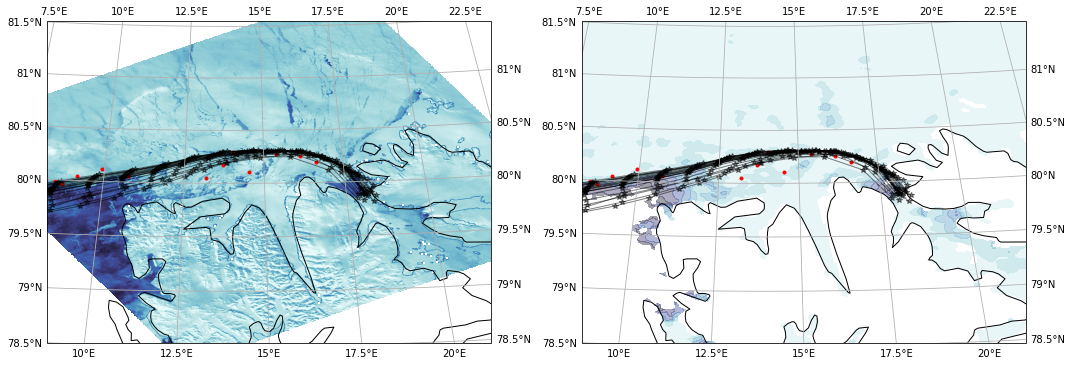

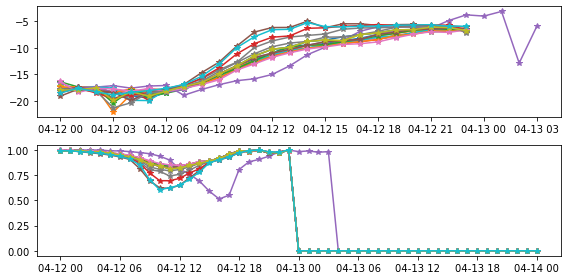

In [287]:
# Create the projection
plot_proj = ccrs.Orthographic(14,25)

fig, ax = plt.subplots(figsize=(15, 8),nrows=1,ncols=2,
                       subplot_kw={'projection': plot_proj})

ax[0].coastlines(resolution='50m')
ax[1].coastlines(resolution='50m')
ax[0].set_extent([9, 21, 78.5, 81.5], crs=ccrs.PlateCarree())
ax[1].set_extent([9, 21, 78.5, 81.5], crs=ccrs.PlateCarree())

# -- Subplot - 1- #
#    MODIS visible satellite picture
contour3 = ax[0].imshow(landsat, transform=ccrs.epsg(3413),cmap=cmocean.cm.ice,extent=(left, right, bottom, top))
# -- Subplot - 2- #
#    AMSR2 sea-ice contour
contour1 = ax[1].contourf(lons, lats, sicn, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice,alpha=0.4)

# 
startdate = date
timesteps_to_loop=1

for dt in range(timesteps_to_loop): #MAKE LOOP
    date = startdate + timedelta(hours=dt*1)
    #------------------------------------------------------------#
    #Find all buoys at date times closer than 29 minutes
    timenow = np.datetime64(date)
    timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10

    for buoy_no in range(np.min(np.shape(timemask))):
        tb = np.where(timemask[buoy_no,:]); #tb = [x[0] for x in tb1]
        if tb:
            ax[0].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())
            ax[1].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())

for ens in range(len(lat[:,0])):         
    ax[0].plot(list(np.squeeze(lon[ens,:])),list(np.squeeze(lat[ens,:])),'-',marker='*',linewidth=1,color='k',transform = ccrs.PlateCarree(),alpha=0.5)
    ax[1].plot(lon[ens,:],lat[ens,:],'-',marker='*',linewidth=1,color='k',transform = ccrs.PlateCarree(),alpha=0.5)

ax[0].gridlines(draw_labels=True)    
ax[1].gridlines(draw_labels=True)

plt.show()

# -- Subplot - 2- #
# -- Temperature forecast #
#ax[1].plot(time,t2m-273.15)


# Display the plot

fig, ax = plt.subplots(figsize=(8, 4),nrows=2,ncols=1)
for ens in range(len(lat[:,0])):
    ax[0].plot(time,t2m[ens,:]-273.15,marker='*')
    ax[1].plot(time,sic[ens,:],marker='*')